In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
#import torch.nn.functional as F


### Part 1

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('credit_score.csv')
df.head(3)

/var/folders/9h/41tfgtlx7vg3_zr70vr31q8w0000gn/T/ipykernel_1659/1842776913.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('credit_score.csv')


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [5]:
nan_count_method_1 = df.isna().sum()
nan_count_method_1

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

In [6]:
mode_by_A = df.groupby('Customer_ID')['Name'].apply(lambda x: len(x.mode()))
mode_by_A.max()

1

Name и Customer_ID совпадают и уникальны. (Будем удалять.)
Затем заполняем NaN в столбце Name, часто встречающимся именем с данным ID:

In [7]:
mode_by_A = df.groupby('Customer_ID')['Name'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
df['Name'] = df.apply(lambda row: mode_by_A[row['Customer_ID']] if pd.isnull(row['Name']) else row['Name'], axis=1)

In [8]:
nan_count_method_1 = df.isna().sum()
nan_count_method_1

ID                              0
Customer_ID                     0
Month                           0
Name                            0
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

Months

Заменем название месяцев на числа

In [9]:
month_to_number = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

In [10]:
df['Month'] = df['Month'].replace(month_to_number)

In [11]:
df.head(3)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,3,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good


Age

In [12]:
df['Age'].head(10)

0      23
1      23
2    -500
3      23
4      23
5      23
6      23
7      23
8     28_
9      28
Name: Age, dtype: object

In [13]:
df['Age'] = pd.to_numeric(df['Age'], errors='coerce').astype(float)

In [14]:
nan_count_method_1 = df.isna().sum()
nan_count_method_1['Age']

4939

Заменили тип столбеца 'Age' object на тип float. Заметили что появились пропуски. Теперь сделаем предположения что возраст от 0 до 110 лет и преобразуем столбец 'Age'.

In [15]:
df['Age'] = df['Age'].apply(lambda x: x if x >= 0  and x < 110 else np.nan)

In [16]:
df['Age'].min(), df['Age'].max()

(14.0, 109.0)

In [17]:
mode_by_A = df.groupby('Customer_ID')['Age'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
df['Age'] = df.apply(lambda row: mode_by_A[row['Customer_ID']] if pd.isnull(row['Age']) else row['Age'], axis=1)

Occupation

In [18]:
df['Occupation'].value_counts()

_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: Occupation, dtype: int64

In [19]:
df['Occupation'] = df['Occupation'].replace('_______', pd.NA)


In [20]:
mode_by_A = df.groupby('Customer_ID')['Occupation'].apply(lambda x: len(x.mode()))

In [21]:
mode_by_A.max()

1

In [22]:
mode_by_A = df.groupby('Customer_ID')['Occupation'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
df['Occupation'] = df.apply(lambda row: mode_by_A[row['Customer_ID']] if pd.isnull(row['Occupation']) else row['Occupation'], axis=1)

In [23]:
df.head(3)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23.0,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23.0,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,3,Aaron Maashoh,23.0,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good


Удалим уникальные столдцы

In [24]:
df.drop(['SSN'], axis=1, inplace=True)

In [25]:
df.drop(['ID'], axis=1, inplace=True)

In [26]:
df.head(3)

,Customer_ID,Month,Name,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,CUS_0xd40,1,Aaron Maashoh,23.0,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,CUS_0xd40,2,Aaron Maashoh,23.0,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,CUS_0xd40,3,Aaron Maashoh,23.0,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good


Annual_Income

In [27]:
df['Annual_Income'] = pd.to_numeric(df['Annual_Income'], errors='coerce').astype(float)
mode_by_A = df.groupby('Customer_ID')['Annual_Income'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)

In [28]:
mode_by_A.head(3)

Customer_ID
CUS_0x1000     30625.94
CUS_0x1009     52312.68
CUS_0x100b    113781.39
Name: Annual_Income, dtype: float64

In [29]:
mode_by_A = df.groupby('Customer_ID')['Annual_Income'].apply(lambda x: len(x.mode()))

In [30]:
mode_by_A.max()

1

Следовательно Annual_Income у всех Customer_ID уникальный. Затем выполним замену:

In [31]:
df['Annual_Income'] = df.apply(lambda row: mode_by_A[row['Customer_ID']] if pd.isnull(row['Annual_Income']) else row['Annual_Income'], axis=1)

Monthly_Inhand_Salary

In [32]:
df['Monthly_Inhand_Salary'] = pd.to_numeric(df['Monthly_Inhand_Salary'], errors='coerce').astype(float)
mode_by_A = df.groupby('Customer_ID')['Monthly_Inhand_Salary'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)

In [33]:
mode_by_A.head(5)

Customer_ID
CUS_0x1000    2706.161667
CUS_0x1009    4250.390000
CUS_0x100b    9549.782500
CUS_0x1011    5208.872500
CUS_0x1013    7962.415000
Name: Monthly_Inhand_Salary, dtype: float64

In [34]:
mode_by_A = df.groupby('Customer_ID')['Monthly_Inhand_Salary'].transform(lambda x: len(x.mode()))

In [35]:
mode_by_A.max()

2

Значения оказались не уникальные, по этому сделаем два столбца

In [36]:
df['Monthly_Inhand_Salary_Change'] = df.groupby('Customer_ID')['Monthly_Inhand_Salary'].transform(lambda x: len(x.mode()))

In [37]:
df.drop(['Monthly_Inhand_Salary'], axis=1, inplace=True)

In [38]:
df.head(3)

,Customer_ID,Month,Name,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Monthly_Inhand_Salary_Change
0,CUS_0xd40,1,Aaron Maashoh,23.0,Scientist,19114.12,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good,1
1,CUS_0xd40,2,Aaron Maashoh,23.0,Scientist,19114.12,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good,1
2,CUS_0xd40,3,Aaron Maashoh,23.0,Scientist,19114.12,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good,1


Num_Bank_Accounts

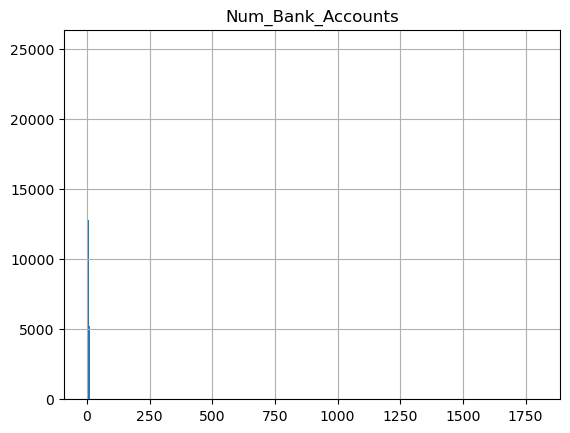

In [39]:
df.hist(column='Num_Bank_Accounts',bins = 1000);

In [40]:
df['Num_Bank_Accounts'].value_counts().head(11)

6     13001
7     12823
8     12765
4     12186
5     12118
3     11950
9      5443
10     5247
1      4490
0      4328
2      4304
Name: Num_Bank_Accounts, dtype: int64

In [41]:
df['Num_Bank_Accounts'].value_counts().tail(11)

928     1
243     1
583     1
1695    1
726     1
987     1
1626    1
1470    1
887     1
211     1
697     1
Name: Num_Bank_Accounts, dtype: int64

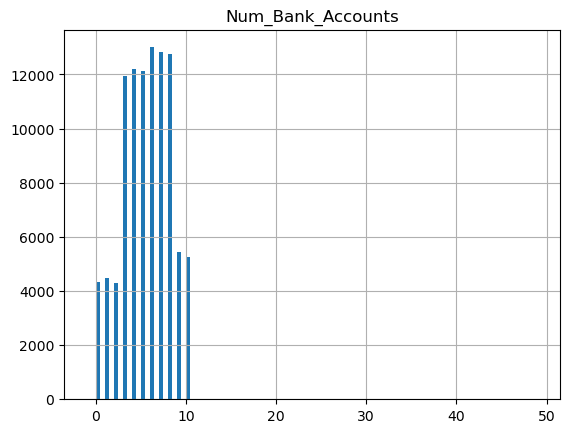

In [42]:
df[df['Num_Bank_Accounts']<50].hist(column='Num_Bank_Accounts',bins = 100);

In [43]:
df['Num_Bank_Accounts'] = pd.to_numeric(df['Num_Bank_Accounts'], errors='coerce').astype(float)
df['Num_Bank_Accounts'] = df['Num_Bank_Accounts'].apply(lambda x: x if x >= 0  and x < 12 else np.nan)

In [44]:
df['Num_Bank_Accounts'] = pd.to_numeric(df['Num_Bank_Accounts'], errors='coerce').astype(float)

In [45]:
#Num_Bank_Accounts_Change
df['Num_Bank_Accounts_Change'] = df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(lambda x: len(x.mode()))

In [46]:
df['Num_Bank_Accounts_Change'].max()

2

In [47]:
mode_by_A = df.groupby('Customer_ID')['Num_Bank_Accounts'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
df['Num_Bank_Accounts'] = df.apply(lambda row: mode_by_A[row['Customer_ID']] if pd.isnull(row['Num_Bank_Accounts']) else row['Num_Bank_Accounts'], axis=1)

Num_Credit_Card

array([[<Axes: title={'center': 'Num_Credit_Card'}>]], dtype=object)

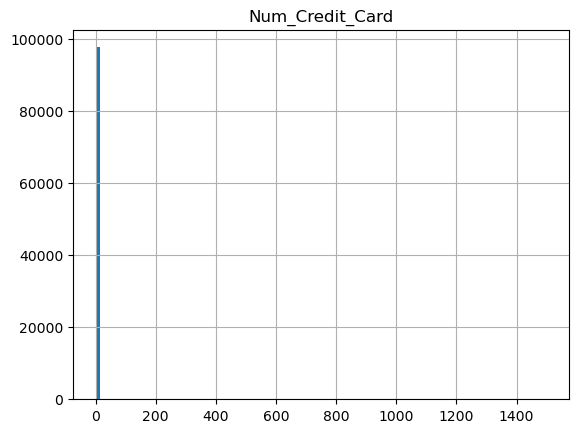

In [50]:
df.hist(column="Num_Credit_Card", bins=100)

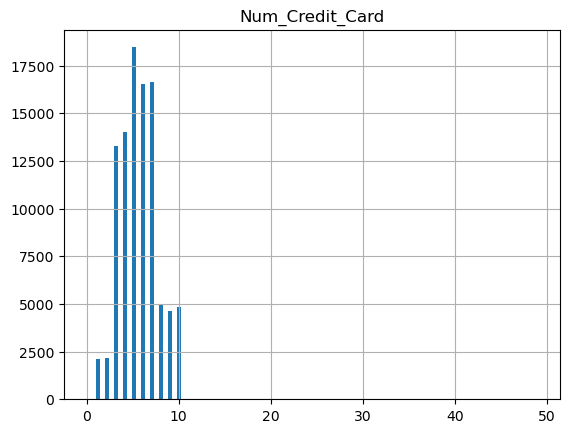

In [51]:
df[df["Num_Credit_Card"]<50].hist(column="Num_Credit_Card", bins=100);

In [52]:
df['Num_Credit_Card'] = pd.to_numeric(df['Num_Credit_Card'], errors='coerce').astype(float)
df['Num_Credit_Card'] = df['Num_Credit_Card'].apply(lambda x: x if x >= 0  and x < 11 else np.nan)
mode_by_A = df.groupby('Customer_ID')['Num_Credit_Card'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
df['Num_Credit_Card'] = df.apply(lambda row: mode_by_A[row['Customer_ID']] if pd.isnull(row['Num_Credit_Card']) else row['Num_Credit_Card'], axis=1)

Interest_Rate

array([[<Axes: title={'center': 'Interest_Rate'}>]], dtype=object)

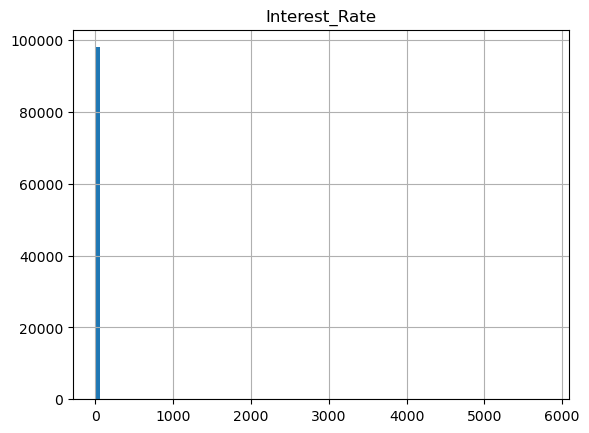

In [54]:
df.hist(column="Interest_Rate", bins=100)

array([[<Axes: title={'center': 'Interest_Rate'}>]], dtype=object)

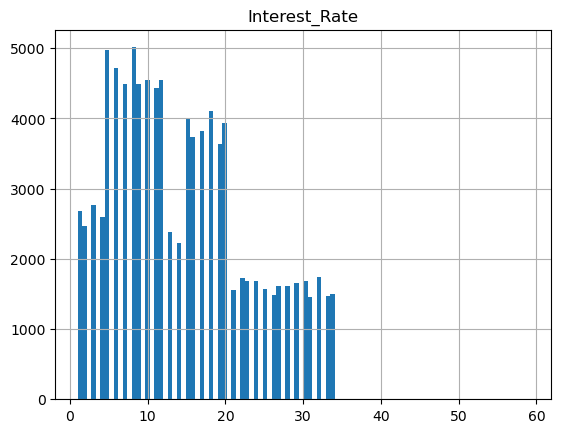

In [55]:
df[df["Interest_Rate"]<60].hist(column="Interest_Rate", bins=100)

In [56]:
df['Interest_Rate'] = pd.to_numeric(df['Interest_Rate'], errors='coerce').astype(float)
df['Interest_Rate'] = df['Interest_Rate'].apply(lambda x: x if x >= 0  and x < 40 else np.nan)
mode_by_A = df.groupby('Customer_ID')['Interest_Rate'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
df['Interest_Rate'] = df.apply(lambda row: mode_by_A[row['Customer_ID']] if pd.isnull(row['Interest_Rate']) else row['Interest_Rate'], axis=1)

Num_of_Loan

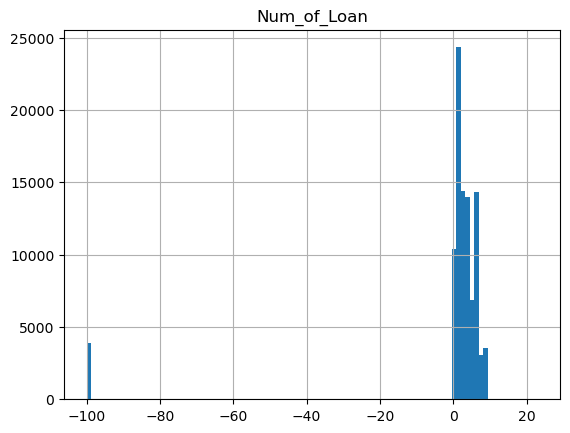

In [57]:
df['Num_of_Loan'] = pd.to_numeric(df['Num_of_Loan'], errors='coerce').astype(float)
df[df["Num_of_Loan"]<25].hist(column="Num_of_Loan", bins=100);

In [58]:
df['Num_of_Loan'] = pd.to_numeric(df['Num_of_Loan'], errors='coerce').astype(float)
df['Num_of_Loan'] = df['Num_of_Loan'].apply(lambda x: x if x >= 0  and x < 15 else np.nan)
mode_by_A = df.groupby('Customer_ID')['Num_of_Loan'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
df['Num_of_Loan'] = df.apply(lambda row: mode_by_A[row['Customer_ID']] if pd.isnull(row['Num_of_Loan']) else row['Num_of_Loan'], axis=1)

Type_of_Loan

In [59]:
df['Type_of_Loan'].head(5)

0    Auto Loan, Credit-Builder Loan, Personal Loan,...
1    Auto Loan, Credit-Builder Loan, Personal Loan,...
2    Auto Loan, Credit-Builder Loan, Personal Loan,...
3    Auto Loan, Credit-Builder Loan, Personal Loan,...
4    Auto Loan, Credit-Builder Loan, Personal Loan,...
Name: Type_of_Loan, dtype: object

In [60]:
df['Type_of_Loan'].value_counts()

Not Specified                                                                                                                         1408
Credit-Builder Loan                                                                                                                   1280
Personal Loan                                                                                                                         1272
Debt Consolidation Loan                                                                                                               1264
Student Loan                                                                                                                          1240
                                                                                                                                      ... 
Not Specified, Mortgage Loan, Auto Loan, and Payday Loan                                                                                 8
Payday Loan, Mortgage Loan,

In [61]:
df.drop(['Type_of_Loan'], axis=1, inplace=True)

Delay_from_due_date

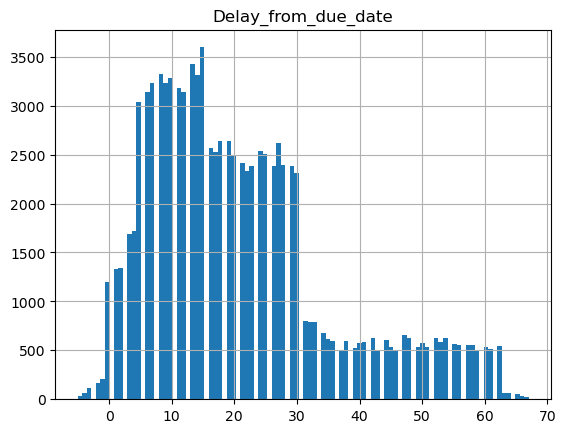

In [62]:
df['Delay_from_due_date'] = pd.to_numeric(df['Delay_from_due_date'], errors='coerce').astype(float)
df[df["Delay_from_due_date"]<70].hist(column="Delay_from_due_date", bins=100);

Num_of_Delayed_Payment

In [64]:
df['Num_of_Delayed_Payment'].head(3)

0      7
1    NaN
2      7
Name: Num_of_Delayed_Payment, dtype: object

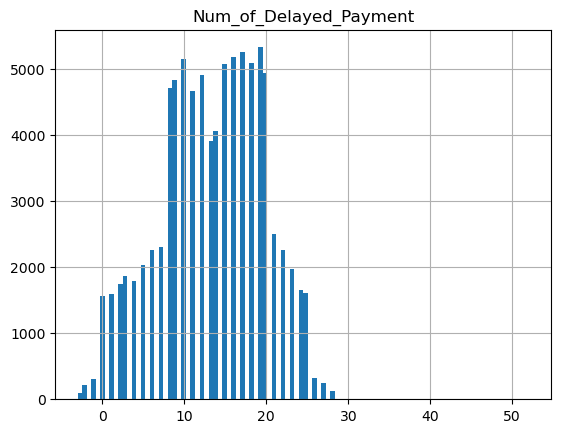

In [65]:
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'], errors='coerce').astype(float)
df[df["Num_of_Delayed_Payment"]<70].hist(column="Num_of_Delayed_Payment", bins=100);

In [66]:
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'], errors='coerce').astype(float)
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].apply(lambda x: x if x >= 0  and x < 30 else np.nan)
mode_by_A = df.groupby('Customer_ID')['Num_of_Delayed_Payment'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
df['Num_of_Delayed_Payment'] = df.apply(lambda row: mode_by_A[row['Customer_ID']] if pd.isnull(row['Num_of_Delayed_Payment']) else row['Num_of_Delayed_Payment'], axis=1)

Changed_Credit_Limit

In [68]:
df['Changed_Credit_Limit'].head(5)

0    11.27
1    11.27
2        _
3     6.27
4    11.27
Name: Changed_Credit_Limit, dtype: object

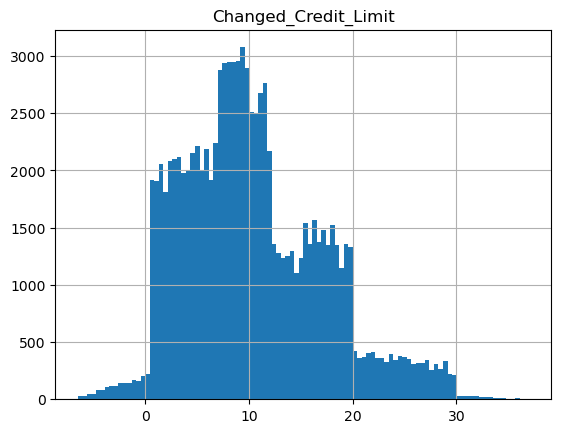

In [69]:
df['Changed_Credit_Limit'] = pd.to_numeric(df['Changed_Credit_Limit'], errors='coerce').astype(float)
df[df["Changed_Credit_Limit"]<70].hist(column="Changed_Credit_Limit", bins=100);

In [70]:
df['Changed_Credit_Limit'] = pd.to_numeric(df['Changed_Credit_Limit'], errors='coerce').astype(float)
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].apply(lambda x: x if x >= -10  and x < 40 else np.nan)
mode_by_A = df.groupby('Customer_ID')['Changed_Credit_Limit'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
df['Changed_Credit_Limit'] = df.apply(lambda row: mode_by_A[row['Customer_ID']] if pd.isnull(row['Changed_Credit_Limit']) else row['Changed_Credit_Limit'], axis=1)

Num_Credit_Inquiries

In [71]:
df['Num_Credit_Inquiries'].max()

2597.0

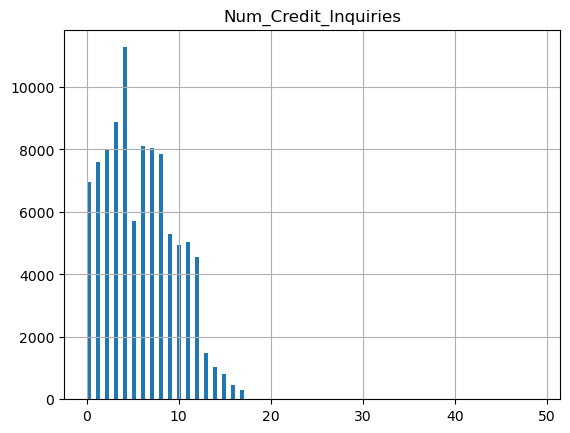

In [72]:
df[df['Num_Credit_Inquiries']<50].hist(column="Num_Credit_Inquiries", bins=100);

In [73]:
df['Num_Credit_Inquiries'] = pd.to_numeric(df['Num_Credit_Inquiries'], errors='coerce').astype(float)
df['Num_Credit_Inquiries'] = df['Num_Credit_Inquiries'].apply(lambda x: x if x >= 0  and x < 20 else np.nan)
mode_by_A = df.groupby('Customer_ID')['Num_Credit_Inquiries'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
df['Num_Credit_Inquiries'] = df.apply(lambda row: mode_by_A[row['Customer_ID']] if pd.isnull(row['Num_Credit_Inquiries']) else row['Num_Credit_Inquiries'], axis=1)

In [74]:
nan_count_method_1 = df['Num_Credit_Inquiries'].isna().sum()
nan_count_method_1

0

Credit_Mix

In [75]:
df['Credit_Mix'].head(5)

0       _
1    Good
2    Good
3    Good
4    Good
Name: Credit_Mix, dtype: object

In [76]:
df['Credit_Mix'].value_counts()

Standard    36479
Good        24337
_           20195
Bad         18989
Name: Credit_Mix, dtype: int64

In [77]:
df['Credit_Mix'] = df['Credit_Mix'].replace('_', pd.NA)

In [78]:
mode_by_A = df.groupby('Customer_ID')['Credit_Mix'].apply(lambda x: len(x.mode()))
mode_by_A.max()

1

In [79]:
mode_by_A = df.groupby('Customer_ID')['Credit_Mix'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
df['Credit_Mix'] = df.apply(lambda row: mode_by_A[row['Customer_ID']] if pd.isnull(row['Credit_Mix']) else row['Credit_Mix'], axis=1)

In [80]:
# Применение метода get_dummies для создания OneHotEncoder
one_hot_encoded = pd.get_dummies(df['Credit_Mix'])
# Объединение исходного датафрейма и OneHotEncoder
df = pd.concat([df, one_hot_encoded], axis=1)
df.head(3)

,Customer_ID,Month,Name,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Monthly_Inhand_Salary_Change,Num_Bank_Accounts_Change,Bad,Good,Standard
0,CUS_0xd40,1,Aaron Maashoh,23.0,Scientist,19114.12,3.0,4.0,3.0,4.0,3.0,7.0,11.27,4.0,Good,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good,1,1,0,1,0
1,CUS_0xd40,2,Aaron Maashoh,23.0,Scientist,19114.12,3.0,4.0,3.0,4.0,-1.0,4.0,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good,1,1,0,1,0
2,CUS_0xd40,3,Aaron Maashoh,23.0,Scientist,19114.12,3.0,4.0,3.0,4.0,3.0,7.0,11.27,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good,1,1,0,1,0


In [81]:
df.drop(['Credit_Mix'], axis=1, inplace=True)

Outstanding_Debt	

In [83]:
df['Outstanding_Debt'].head(5)

0    809.98
1    809.98
2    809.98
3    809.98
4    809.98
Name: Outstanding_Debt, dtype: object

In [85]:
df['Outstanding_Debt'] = pd.to_numeric(df['Outstanding_Debt'], errors='coerce').astype(float)

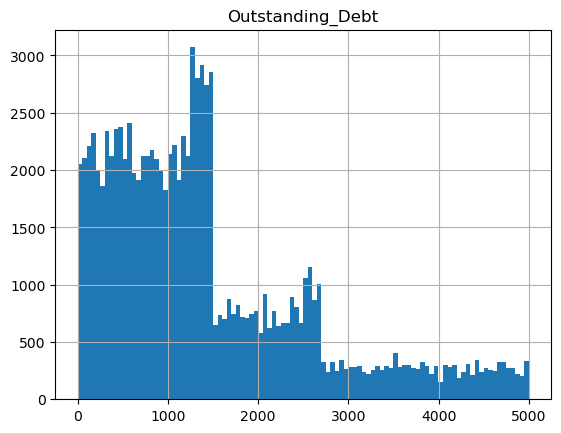

In [86]:
df.hist(column="Outstanding_Debt", bins=100);

In [97]:
mode_by_A = df.groupby('Customer_ID')['Outstanding_Debt'].apply(lambda x: len(x.mode()))
mode_by_A.max()

1

In [98]:
df['Outstanding_Debt'] = df.apply(lambda row: mode_by_A[row['Customer_ID']] if pd.isnull(row['Outstanding_Debt']) else row['Outstanding_Debt'], axis=1)

Credit_Utilization_Ratio

In [87]:
df['Credit_Utilization_Ratio'].head(5)

0    26.822620
1    31.944960
2    28.609352
3    31.377862
4    24.797347
Name: Credit_Utilization_Ratio, dtype: float64

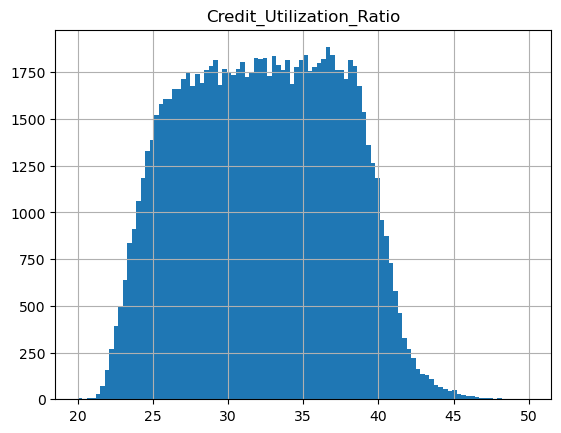

In [88]:
df.hist(column="Credit_Utilization_Ratio", bins=100);

Credit_History_Age

In [89]:
def test_Credit_History_Age(a):
    return a.split(" ")[0]

In [90]:
df['Credit_History_Age'] = df['Credit_History_Age'].str.extract(r'(\d+)').astype(np.float32)

In [91]:
df['Credit_History_Age'].head(5)

0    22.0
1     NaN
2    22.0
3    22.0
4    22.0
Name: Credit_History_Age, dtype: float32

In [92]:
nan_count_method_1 = df['Credit_History_Age'].isna().sum()
nan_count_method_1

9030

In [93]:
mode_by_A = df.groupby('Customer_ID')['Credit_History_Age'].apply(lambda x: len(x.mode()))
mode_by_A.max()

2

In [94]:
df['Credit_History_Age_Change'] = df.groupby('Customer_ID')['Credit_History_Age'].transform(lambda x: len(x.mode()))
df.drop(['Credit_History_Age'], axis=1, inplace=True)

Payment_of_Min_Amount

In [101]:
df["Payment_of_Min_Amount"].value_counts()

Yes    52326
No     35667
NM     12007
Name: Payment_of_Min_Amount, dtype: int64

In [102]:
filter_df = df[df['Payment_of_Min_Amount'] == 'NM']
filter_df['Payment_of_Min_Amount'].head(3)

14    NM
26    NM
33    NM
Name: Payment_of_Min_Amount, dtype: object

Неизвестное значение NM заменим на Null

In [ ]:
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace('NM', pd.NA)

In [119]:
df["Payment_of_Min_Amount"].value_counts()

Yes    52326
No     35667
Name: Payment_of_Min_Amount, dtype: int64

In [103]:
mode_by_A = df.groupby('Customer_ID')['Payment_of_Min_Amount'].apply(lambda x: len(x.mode()))
mode_by_A.max()

2

In [105]:
# Изменяем тип данных столбца на bool
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace({'Yes': 1, 'No': 0})

In [ ]:
df['Payment_of_Min_Amount_Change'] = df.groupby('Customer_ID')['Payment_of_Min_Amount'].transform(lambda x: len(x.mode()))
df.drop(['Payment_of_Min_Amount'], axis=1, inplace=True)

In [109]:
df["Payment_of_Min_Amount_Change"].value_counts()

1    99216
2      784
Name: Payment_of_Min_Amount_Change, dtype: int64

Total_EMI_per_month

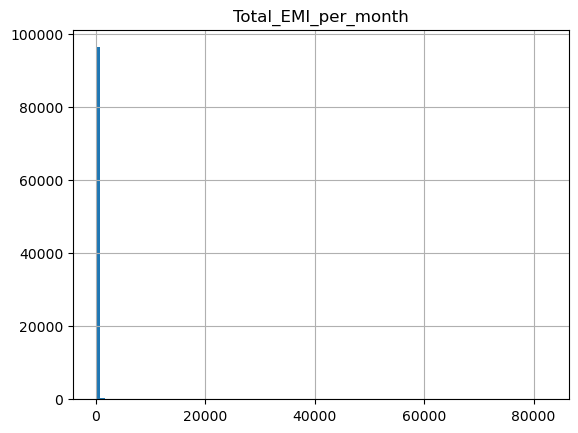

In [111]:
df.hist(column="Total_EMI_per_month", bins=100);

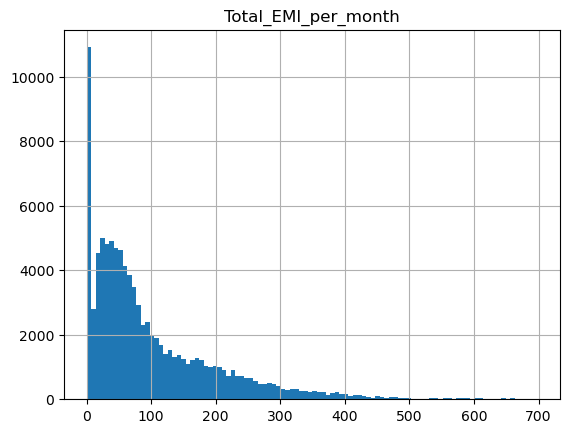

In [112]:
df[df["Total_EMI_per_month"]<700].hist(column="Total_EMI_per_month", bins=100);

In [116]:
df['Total_EMI_per_month'] = pd.to_numeric(df['Total_EMI_per_month'], errors='coerce').astype(float)
df['Total_EMI_per_month'] = df['Total_EMI_per_month'].apply(lambda x: x if x > 0  and x < 700 else np.nan)
mode_by_A = df.groupby('Customer_ID')['Total_EMI_per_month'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)

In [117]:
mode_by_A.max()

696.2149440750084

In [122]:
df.drop(['Total_EMI_per_month'], axis=1, inplace=True)

Amount_invested_monthly

In [124]:
df['Amount_invested_monthly'] = pd.to_numeric(df['Amount_invested_monthly'], errors='coerce').astype(float)

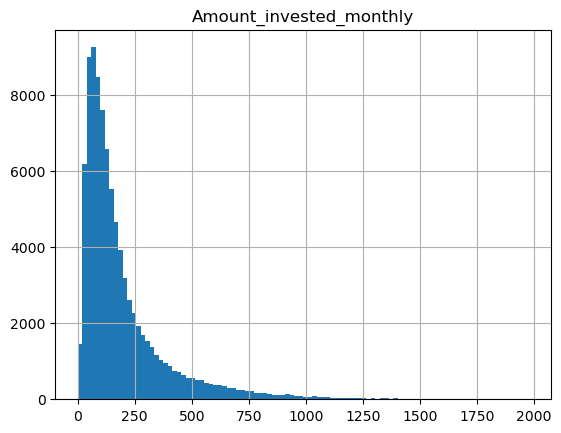

In [125]:
df.hist(column="Amount_invested_monthly", bins=100);

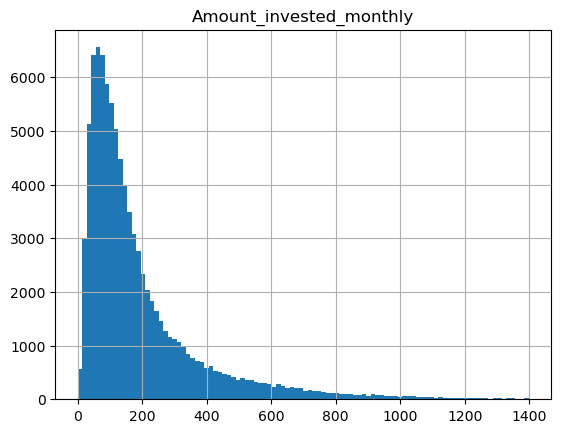

In [126]:
df[df["Amount_invested_monthly"]<1400].hist(column="Amount_invested_monthly", bins=100);

In [127]:
df['Amount_invested_monthly'] = pd.to_numeric(df['Amount_invested_monthly'], errors='coerce').astype(float)
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].apply(lambda x: x if x >= 0  and x < 1400 else np.nan)
mode_by_A = df.groupby('Customer_ID')['Amount_invested_monthly'].apply(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
mode_by_A.max() 
#df['Amount_invested_monthly'] = df.apply(lambda row: mode_by_A[row['Customer_ID']] if pd.isnull(row['Amount_invested_monthly']) else row['Amount_invested_monthly'], axis=1)

510.7262372637133

In [128]:
df.drop(['Amount_invested_monthly'], axis=1, inplace=True)

Payment_Behaviour

In [129]:
df['Payment_Behaviour'].head(5)

0     High_spent_Small_value_payments
1      Low_spent_Large_value_payments
2     Low_spent_Medium_value_payments
3      Low_spent_Small_value_payments
4    High_spent_Medium_value_payments
Name: Payment_Behaviour, dtype: object

In [130]:
df['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: Payment_Behaviour, dtype: int64

In [131]:
df['Payment_Behaviour'] = df['Payment_Behaviour'].replace('!@9#%8', pd.NA)

In [134]:
df.drop(['Payment_Behaviour'], axis=1, inplace=True)

Monthly_Balance

In [135]:
df['Monthly_Balance'].head(5)

0    312.49408867943663
1    284.62916249607184
2     331.2098628537912
3    223.45130972736786
4    341.48923103222177
Name: Monthly_Balance, dtype: object

In [136]:
df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors='coerce').astype(float)

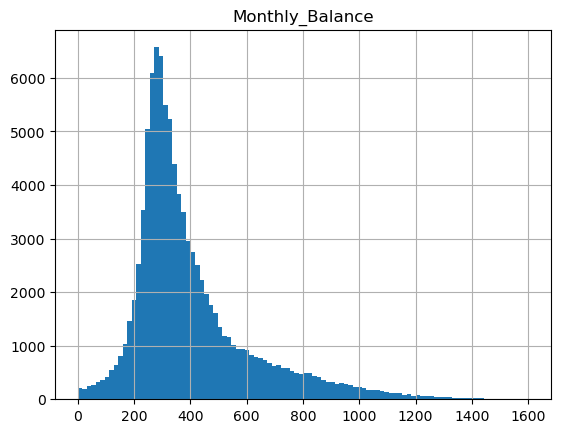

In [137]:
df.hist(column="Monthly_Balance", bins=100);

In [138]:
df.drop(['Monthly_Balance'], axis=1, inplace=True)

Credit_Score

In [139]:
df['Credit_Score'].value_counts()

Standard    53174
Poor        28998
Good        17828
Name: Credit_Score, dtype: int64

In [140]:
score_to_number = {
    'Poor': 0,
    'Standard': 1,
    'Good': 2
}

In [141]:
df['Credit_Score'] = df['Credit_Score'].replace(score_to_number).astype(int)

In [142]:
df['Credit_Score'].value_counts()

2    53174
1    28998
3    17828
Name: Credit_Score, dtype: int64

### Part 2

Сделали предобработку данных. Готовимся к обучению:

In [143]:
df.head(5)

,Customer_ID,Month,Name,Age,Occupation,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_Score,Monthly_Inhand_Salary_Change,Num_Bank_Accounts_Change,Bad,Good,Standard,Credit_History_Age_Change,Payment_of_Min_Amount_Change
0,CUS_0xd40,1,Aaron Maashoh,23.0,Scientist,19114.12,3.0,4.0,3.0,4.0,3.0,7.0,11.27,4.0,809.98,26.822620,3,1,1,0,1,0,1,1
1,CUS_0xd40,2,Aaron Maashoh,23.0,Scientist,19114.12,3.0,4.0,3.0,4.0,-1.0,4.0,11.27,4.0,809.98,31.944960,3,1,1,0,1,0,1,1
2,CUS_0xd40,3,Aaron Maashoh,23.0,Scientist,19114.12,3.0,4.0,3.0,4.0,3.0,7.0,11.27,4.0,809.98,28.609352,3,1,1,0,1,0,1,1
3,CUS_0xd40,4,Aaron Maashoh,23.0,Scientist,19114.12,3.0,4.0,3.0,4.0,5.0,4.0,6.27,4.0,809.98,31.377862,3,1,1,0,1,0,1,1
4,CUS_0xd40,5,Aaron Maashoh,23.0,Scientist,19114.12,3.0,4.0,3.0,4.0,6.0,4.0,11.27,4.0,809.98,24.797347,3,1,1,0,1,0,1,1


In [144]:
df.to_csv('v3_credit_score_with_Name-Customer_ID.csv')

In [3]:
df = pd.read_csv('v3_credit_score_with_Name-Customer_ID.csv')

In [ ]:
df

In [5]:
df.drop(['Name', 'Customer_ID', 'Unnamed: 0'],axis=1,inplace=True)

In [7]:
df.drop(['Annual_Income', 'Payment_of_Min_Amount_Change', 'Credit_History_Age_Change', 'Num_Bank_Accounts_Change', 'Monthly_Inhand_Salary_Change'],axis=1,inplace=True)

/var/folders/9h/41tfgtlx7vg3_zr70vr31q8w0000gn/T/ipykernel_1251/3738696617.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrs = df.corr().round(3).sort_values('Credit_Score')


<Axes: >

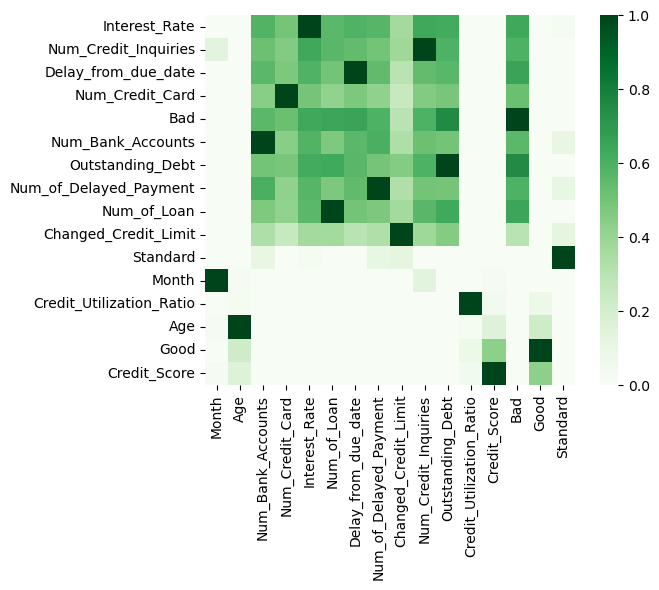

In [8]:
corrs = df.corr().round(3).sort_values('Credit_Score')
sns.heatmap(corrs,
            cmap = 'Greens',
            square=True,
            vmin = 0)

In [9]:
df.to_csv('v4_credit_score_with_Name-Customer_ID.csv')

### Part 3 Torch

In [2]:
df = pd.read_csv('v4_credit_score_with_Name-Customer_ID.csv')
df.drop(['Unnamed: 0', 'Occupation'],axis=1,inplace=True)
df.head(5)

,Month,Age,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_Score,Bad,Good,Standard
0,1,23.0,3.0,4.0,3.0,4.0,3.0,7.0,11.27,4.0,809.98,26.822620,3,0,1,0
1,2,23.0,3.0,4.0,3.0,4.0,-1.0,4.0,11.27,4.0,809.98,31.944960,3,0,1,0
2,3,23.0,3.0,4.0,3.0,4.0,3.0,7.0,11.27,4.0,809.98,28.609352,3,0,1,0
3,4,23.0,3.0,4.0,3.0,4.0,5.0,4.0,6.27,4.0,809.98,31.377862,3,0,1,0
4,5,23.0,3.0,4.0,3.0,4.0,6.0,4.0,11.27,4.0,809.98,24.797347,3,0,1,0


In [3]:
#fix
df['Credit_Score'] = df['Credit_Score'].replace([1,2,3],[0,1,2])

Разделение данных на обучающий и тестовый наборы

In [4]:
X = df.drop(['Credit_Score'], axis=1, errors = 'ignore')
y = df['Credit_Score'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
X.head(10)

,Month,Age,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Bad,Good,Standard
0,1,23.0,3.0,4.0,3.0,4.0,3.0,7.0,11.27,4.0,809.98,26.822620,0,1,0
1,2,23.0,3.0,4.0,3.0,4.0,-1.0,4.0,11.27,4.0,809.98,31.944960,0,1,0
2,3,23.0,3.0,4.0,3.0,4.0,3.0,7.0,11.27,4.0,809.98,28.609352,0,1,0
3,4,23.0,3.0,4.0,3.0,4.0,5.0,4.0,6.27,4.0,809.98,31.377862,0,1,0
4,5,23.0,3.0,4.0,3.0,4.0,6.0,4.0,11.27,4.0,809.98,24.797347,0,1,0
5,6,23.0,3.0,4.0,3.0,4.0,8.0,4.0,9.27,4.0,809.98,27.262259,0,1,0
6,7,23.0,3.0,4.0,3.0,4.0,3.0,4.0,11.27,4.0,809.98,22.537593,0,1,0
7,8,23.0,3.0,4.0,3.0,4.0,3.0,6.0,11.27,4.0,809.98,23.933795,0,1,0
8,1,28.0,2.0,4.0,6.0,1.0,3.0,4.0,5.42,2.0,605.03,24.464031,0,1,0
9,2,28.0,2.0,4.0,6.0,1.0,7.0,1.0,7.42,2.0,605.03,38.550848,0,1,0


----------

In [6]:
class Data(Dataset):
  '''Dataset Class to store the samples and their corresponding labels, 
  and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.
  '''

  def __init__(self, X: np.ndarray, y: np.ndarray) -> None:

    # need to convert float64 to float32 else 
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X.astype(np.float32))
    self.y = torch.from_numpy(y.astype(np.float32))
    self.len = self.X.shape[0]
  
  def __getitem__(self, index: int) -> tuple:
    return self.X[index], self.y[index]

  def __len__(self) -> int:
    return self.len

In [7]:
batch_size = 64

# Generate the training dataset
traindata = Data(X_train.values, y_train.values)

# Load the training data into data loader with the 
# respective batch_size and num_workers 
# num_workers: Количество потоков для подготовки данных. Позволяет ускорить загрузку данных.
trainloader = DataLoader(traindata, batch_size=batch_size, 
                         shuffle=True, num_workers=0)

In [8]:
testdata = Data(X_test.values, y_test.values)
testloader = DataLoader(testdata, batch_size=batch_size, 
                        shuffle=True, num_workers=0)

--------

Решение задачи мультиклассовой классификации

In [9]:
NUM_CLASSES = 3
NUM_FEATURES = X_train.shape[1]

In [10]:
class MulticlassClassification(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int) -> None:
    
        super().__init__()
        self.input_to_hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden_layer_1 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_to_output = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # no activation and no softmax at the end
        x = self.relu(self.input_to_hidden(x))
        x = self.relu(self.hidden_layer_1(x))
        x = self.relu(self.hidden_layer_2(x))
        x = self.hidden_to_output(x)
        return x


In [11]:
# number of features (len of X cols)
input_dim = NUM_FEATURES
# number of hidden layers
hidden_layers = 100
# output dimension is 3 because of Multiclass Classification
output_dim = NUM_CLASSES
# initiate the Multiclass Classification model
model = MulticlassClassification(input_dim, hidden_layers, output_dim)

print(model)

MulticlassClassification(
  (input_to_hidden): Linear(in_features=15, out_features=100, bias=True)
  (hidden_layer_1): Linear(in_features=100, out_features=100, bias=True)
  (hidden_layer_2): Linear(in_features=100, out_features=100, bias=True)
  (hidden_to_output): Linear(in_features=100, out_features=3, bias=True)
  (relu): ReLU()
)


In [12]:
# Опишем функцию потерь и оптимизатор
loss_fn = nn.CrossEntropyLoss() #nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.01)

In [13]:
# Вычисление точности
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [15]:
# start training
epochs = 1000
for epoch in range(epochs):
  running_loss = 0.0
  for i, (inputs, labels) in enumerate(trainloader):
    # inputs, labels = data

    # forward propagation
    outputs = model(inputs)
    loss = loss_fn(outputs, labels.type(torch.LongTensor))

    # set optimizer to zero grad 
    # to remove previous epoch gradients
    optimizer.zero_grad()

    # backward propagation
    loss.backward()

    # optimize
    optimizer.step()
    running_loss += loss.item()

  # display statistics
  if not ((epoch + 1) % (epochs // 10)):
    print(f'Epochs:{epoch + 1:5d} | ' \
          f'Batches per epoch: {i + 1:3d} | ' \
          f'Loss: {running_loss / (i + 1):.10f}')

Epochs:  100 | Batches per epoch: 1250 | Loss: nan
Epochs:  200 | Batches per epoch: 1250 | Loss: nan
Epochs:  300 | Batches per epoch: 1250 | Loss: nan
Epochs:  400 | Batches per epoch: 1250 | Loss: nan
Epochs:  500 | Batches per epoch: 1250 | Loss: nan
Epochs:  600 | Batches per epoch: 1250 | Loss: nan
Epochs:  700 | Batches per epoch: 1250 | Loss: nan
Epochs:  800 | Batches per epoch: 1250 | Loss: nan
Epochs:  900 | Batches per epoch: 1250 | Loss: nan
Epochs: 1000 | Batches per epoch: 1250 | Loss: nan


--------

In [27]:
model.eval()
# Validate trained model using the test dataset
with torch.no_grad():
  loss = 0
  for i, (inputs, labels) in enumerate(testloader):
    # calculate output by running through the network
    predictions = model(inputs) #-test_logits = model(X_test_tensor)
    #labels = torch.from_numpy(y_scaler.inverse_transform(labels))
    #predictions = torch.from_numpy(y_scaler.inverse_transform(predictions))
    loss += loss_fn(predictions, labels.type(torch.LongTensor)) #-test_loss = loss_fn(test_logits, y_test_tensor)
  print(f'MSE Loss: {loss / (i + 1):.5f}')

MSE Loss: 53.84216


In [ ]:
### Тестирование
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test_tensor)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            
            test_loss = loss_fn(test_logits, y_test_tensor)
            test_acc = accuracy_fn(y_true=y_test_tensor,
                                 y_pred=test_pred)


------------

In [153]:
cat_cols = ['Occupation']
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1,eval_metric='AUC')
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=100, plot=True, 
          early_stopping_rounds=100)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.117866
0:	test: 0.8497687	best: 0.8497687 (0)	total: 95.1ms	remaining: 1m 35s
100:	test: 0.8990728	best: 0.8990728 (100)	total: 2.49s	remaining: 22.2s
200:	test: 0.9056482	best: 0.9056482 (200)	total: 4.89s	remaining: 19.5s
300:	test: 0.9094897	best: 0.9094897 (300)	total: 7.23s	remaining: 16.8s
400:	test: 0.9121722	best: 0.9121722 (400)	total: 9.67s	remaining: 14.4s
500:	test: 0.9151292	best: 0.9151292 (500)	total: 12s	remaining: 11.9s
600:	test: 0.9178913	best: 0.9178913 (600)	total: 14.4s	remaining: 9.54s
700:	test: 0.9200359	best: 0.9200359 (700)	total: 16.7s	remaining: 7.14s
800:	test: 0.9220609	best: 0.9220609 (800)	total: 19.1s	remaining: 4.74s
900:	test: 0.9233513	best: 0.9233513 (900)	total: 21.6s	remaining: 2.38s
999:	test: 0.9246766	best: 0.9246766 (999)	total: 24.1s	remaining: 0us

bestTest = 0.9246765721
bestIteration = 999



In [156]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = pred.reshape(20000)
confusion_matrix(y_test,pred)

array([[4326, 1294,  254],
       [1287, 8357,  955],
       [  61, 1026, 2440]])

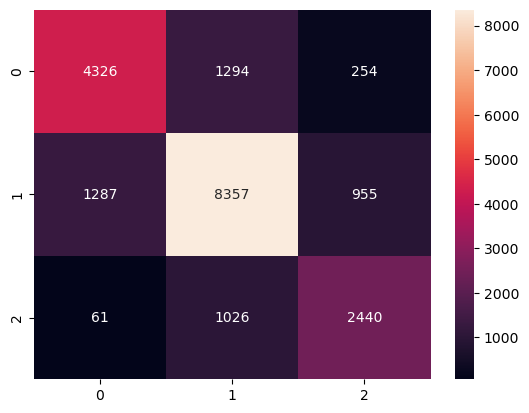

In [157]:
import seaborn as sns
cm = confusion_matrix(y_test,pred)

sns.heatmap(cm, annot=True , fmt=".0f");